# Analyze results of FP32 vs FP16 Quantization

In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import json
from PIL import Image
from notebook_utils import load_mpl_style

import matplotlib.pyplot as plt

load_mpl_style()
fig_dir = "figures/quantization"
os.makedirs(fig_dir, exist_ok=True)

## Load metrics from scene JSON files

In [2]:
def load_results(results_dir: str) -> dict:
    results = {}
    for scene in sorted(os.listdir(results_dir)):
        if scene == ".DS_Store":
            continue
        metrics_path = os.path.join(results_dir, scene, "render_metrics.json")
        with open(metrics_path, "r") as f:
            results[scene] = json.load(f)
    print(f"Loaded {len(results)} scene results from {results_dir}")
    return results

results_fp32 = load_results("../results")
results_fp16 = load_results("../results_fp16")

Loaded 8 scene results from ../results
Loaded 8 scene results from ../results_fp16


In [3]:
df_fp32 = pd.DataFrame.from_dict(results_fp32, orient="index")
df_fp16 = pd.DataFrame.from_dict(results_fp16, orient="index")
assert df_fp16['use_fp16'].all()

In [4]:
# Merge results into single dataframe
df_compare = df_fp32.copy()
df_compare = df_compare.drop(
    columns=["use_fp16", "scene", "checkpoint", "num_downscales", 
             "psnrs", "lpips", "og_size", "quantized_size"]
)
df_compare = df_compare.add_prefix('fp32_')

df_fp16_relevant = df_fp16[["render_time", "psnr_avg", "power_draw_avg", "energy", "lpips_avg"]]
df_fp16_relevant = df_fp16_relevant.add_prefix('fp16_')

df_compare = df_compare.join(df_fp16_relevant)
df_compare

,fp32_render_time,fp32_psnr_avg,fp32_power_draw_avg,fp32_energy,fp32_lpips_avg,fp16_render_time,fp16_psnr_avg,fp16_power_draw_avg,fp16_energy,fp16_lpips_avg
chair,116.754415,35.106121,322.745,37681.903532,0.025573,43.742688,33.905234,269.685,11796.746798,0.031763
drums,121.699046,26.245696,322.890,39295.404817,0.064089,44.754623,25.934531,271.530,12152.222751,0.070676
ficus,60.629561,32.927028,303.205,18383.186188,0.018331,26.214829,32.065000,251.020,6580.446429,0.023544
hotdog,243.523932,36.930002,338.745,82492.514375,0.032591,81.122944,36.241094,292.390,23719.537453,0.036598
lego,154.571539,33.719887,323.375,49984.571543,0.027929,54.092843,32.742109,293.780,15891.395431,0.033588
materials,148.086400,30.339982,321.120,47553.504713,0.043826,51.447307,29.861328,285.450,14685.633703,0.052197
mic,59.074304,34.590227,296.825,17534.730168,0.020263,26.517859,33.516250,239.965,6363.357980,0.027399
ship,354.269128,29.849499,336.880,119346.183849,0.150662,114.588152,29.433750,315.865,36194.386755,0.156542


### PSNR Difference table

In [5]:
df_compare["psnr_diff"] = 100 * (df_compare["fp32_psnr_avg"] - df_compare["fp16_psnr_avg"]) / df_compare["fp32_psnr_avg"]
df_psnr = df_compare[["fp32_psnr_avg", "fp16_psnr_avg", "psnr_diff"]].copy()
df_psnr["fp32_psnr_avg"] = df_psnr["fp32_psnr_avg"].round(2).astype(str)
df_psnr["fp16_psnr_avg"] = df_psnr["fp16_psnr_avg"].round(2).astype(str)
df_psnr["psnr_diff"] = df_psnr["psnr_diff"].round(2).astype(str) + '%'
df_psnr.columns = ["PSNR (FP32)", "PSNR (FP16)", "Decrease (%)"]

print(df_psnr.to_latex(escape=True))
df_psnr

\begin{tabular}{llll}
\toprule
 & PSNR (FP32) & PSNR (FP16) & Decrease (\%) \\
\midrule
chair & 35.11 & 33.91 & 3.42\% \\
drums & 26.25 & 25.93 & 1.19\% \\
ficus & 32.93 & 32.06 & 2.62\% \\
hotdog & 36.93 & 36.24 & 1.87\% \\
lego & 33.72 & 32.74 & 2.9\% \\
materials & 30.34 & 29.86 & 1.58\% \\
mic & 34.59 & 33.52 & 3.1\% \\
ship & 29.85 & 29.43 & 1.39\% \\
\bottomrule
\end{tabular}



,PSNR (FP32),PSNR (FP16),Decrease (%)
chair,35.11,33.91,3.42%
drums,26.25,25.93,1.19%
ficus,32.93,32.06,2.62%
hotdog,36.93,36.24,1.87%
lego,33.72,32.74,2.9%
materials,30.34,29.86,1.58%
mic,34.59,33.52,3.1%
ship,29.85,29.43,1.39%


### Compute the speedup ratio and energy ratio between FP32 and FP16

`ratio = fp32_metric / fp16_metric`

In [6]:
df_compare["render_speedup"] = df_compare["fp32_render_time"] / df_compare["fp16_render_time"]
df_compare["render_speedup"]

chair        2.669118
drums        2.719251
ficus        2.312796
hotdog       3.001912
lego         2.857523
materials    2.878409
mic          2.227718
ship         3.091673
Name: render_speedup, dtype: float64

In [7]:
df_compare["energy_improvement"] = df_compare["fp32_energy"] / df_compare["fp16_energy"]
df_compare["energy_improvement"]

chair        3.194262
drums        3.233598
ficus        2.793608
hotdog       3.477830
lego         3.145386
materials    3.238097
mic          2.755578
ship         3.297367
Name: energy_improvement, dtype: float64

### Plot grouped barchart

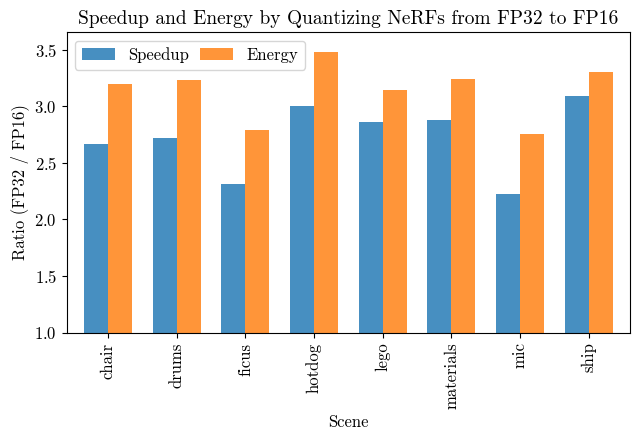

In [8]:
ax = df_compare.plot.bar(
    y=["render_speedup", "energy_improvement"], 
    width=0.7, figsize=(6.5, 4.5), align="center", alpha=0.825
)
ax.set_ylim(bottom=1.0)
ax.legend(['Speedup', 'Energy'], loc="upper left", ncol=2, columnspacing=0.65)

ax.set_title("Speedup and Energy by Quantizing NeRFs from FP32 to FP16")
ax.set_xlabel("Scene")
ax.set_ylabel("Ratio (FP32 / FP16)")
ax.figure.tight_layout()
ax.figure.savefig(f"{fig_dir}/quantization_results.pdf")
ax.figure.savefig("../assets/quantization-results.png", dpi=300)

## Show image comparison of FP32 and FP16
We render 800x800 images in this case so we can more easily see the details.

In [9]:
gt_rgb = np.asarray(Image.open("quantization/gt_rgb_0065.png"))
fp32_rgb = np.asarray(Image.open("quantization/lego_rgb_0065_fp32.png"))
fp16_rgb = np.asarray(Image.open("quantization/lego_rgb_0065_fp16.png"))

with open("quantization/render_metrics_fp32.json", "r") as f:
    fp32_metrics = json.load(f)
    
with open("quantization/render_metrics_fp16.json", "r") as f:
    fp16_metrics = json.load(f)
    
fp32_psnr = fp32_metrics["psnrs"]
assert len(fp32_psnr) == 1
fp32_psnr = fp32_psnr[0]

fp16_psnr = fp16_metrics["psnrs"]
assert len(fp16_psnr) == 1
fp16_psnr = fp16_psnr[0]

print(f"PSNR. fp32 = {fp32_psnr}, fp16 = {fp16_psnr}")

PSNR. fp32 = 35.13179016113281, fp16 = 32.78125


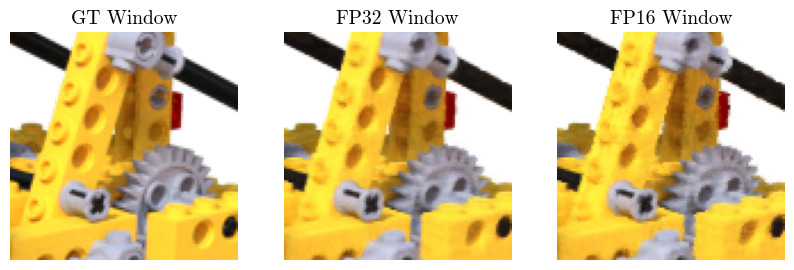

In [10]:
# Window to extract from the image
start_y, end_y = 245, 345
start_x, end_x = 485, 585

plt.figure(figsize=(10, 5))
for idx, (im, label) in enumerate([
    (gt_rgb, "GT"),
    (fp32_rgb, "FP32"),
    (fp16_rgb, "FP16")
]):
    plt.subplot(1, 3, idx + 1)
    plt.imshow(im[start_y:end_y, start_x:end_x])
    plt.title(f"{label} Window")
    plt.axis("off")
plt.show()

In [11]:
def get_fig(im_rgb, offset_x: int = 25, offset_y: int = 530, scale_window: float = 2.0, crop_border: int = 10):
    """ Create the figure from the RGB image """
    window = im_rgb[start_y:end_y, start_x:end_x]
    window_h, window_w, *_ = window.shape

    if scale_window != 1.0:
        window_h = int(window_h * scale_window)
        window_w = int(window_w * scale_window)
        window = cv2.resize(window, dsize=(window_h, window_w))

    im_h, im_w, *_ = im_rgb.shape

    # Compute indices of window in new fig
    w_start_x = im_w - offset_x - window_w
    w_end_x = w_start_x + window_w
    w_start_y = offset_y
    w_end_y = w_start_y + window_h

    # Copy RGB and create fig
    im_fig = im_rgb.copy()
    # Add alpha channel if it doesn't exist
    if im_fig.shape[-1] == 3:
        im_fig = np.concatenate([im_fig, np.ones_like(im_fig[..., :1]) * 255], axis=-1)

    # Highlight window in red
    border_color = np.array([255.0, 50.0, 50.0, 255.0])
    cv2.rectangle(im_fig, (start_x, start_y), (end_x, end_y), border_color, 3)
    
    # Draw lines to the window
    cv2.line(im_fig, (start_x, start_y), (w_start_x, w_start_y), border_color, 2)
    cv2.line(im_fig, (end_x, end_y), (w_end_x, w_end_y), border_color, 2)
    cv2.line(im_fig, (start_x, end_y), (w_start_x, w_end_y), border_color, 2)
    cv2.line(im_fig, (end_x, start_y), (w_end_x, w_start_y), border_color, 2)

    # Add window
    im_fig[w_start_y:w_end_y, w_start_x:w_end_x, :window.shape[-1]] = window
    cv2.rectangle(im_fig, (w_start_x, w_start_y), (w_end_x, w_end_y), border_color, 3)
    
    # Crop to content, numbers gotten from GT
    crop_start_y, crop_end_y, crop_start_x, crop_end_x = 104, 742, 26, 787
#     mask = (im_fig[..., :3] == 0).all(axis=-1)
#     non_white_pix = np.where(mask == False)
#     border = crop_border
#     crop_start_y, crop_end_y = non_white_pix[0].min() - border, non_white_pix[0].max() + border
#     crop_start_x, crop_end_x = non_white_pix[1].min() - border, non_white_pix[1].max() + border
#     print(crop_start_y, crop_end_y, crop_start_x, crop_end_x)
    cropped_im_fig = im_fig[crop_start_y:crop_end_y, crop_start_x:crop_end_x]
    return cropped_im_fig


def hide_ax_except_labels(ax):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    for direction in ["top", "right", "left", "bottom"]:
        ax.spines[direction].set_visible(False)

NameError: name 'crop_start_x' is not defined

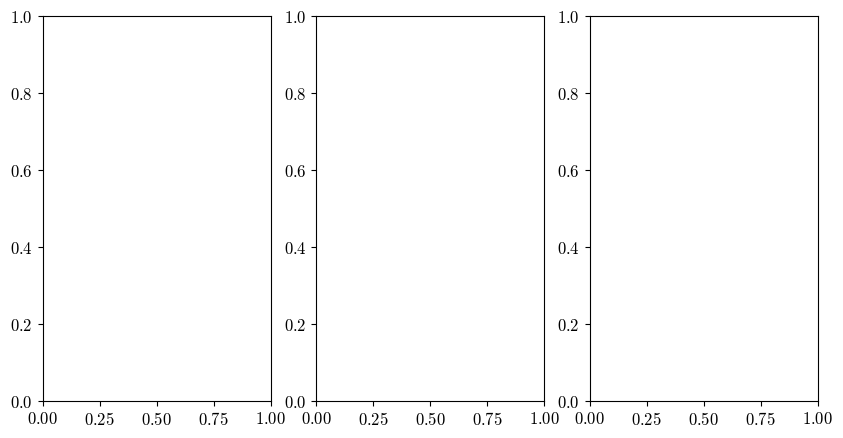

In [12]:
# Create merged figure - ONLY for visualization purposes
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
for idx, (im, label, psnr) in enumerate([
    (gt_rgb, "Ground Truth", None),
    (fp32_rgb, "FP32", fp32_psnr),
    (fp16_rgb, "FP16", fp16_psnr)
]):
    im_fig = get_fig(im)
    # Save image as PNG
    fname = label.lower().replace(" ", "-") + "_lego.png"
    cv2.imwrite(f"{fig_dir}/{fname}", cv2.cvtColor(im_fig, cv2.COLOR_RGB2BGR))
    # Show in plot
    ax = axs[idx]
    ax.imshow(im_fig)
    ax.set_title(label)
    hide_ax_except_labels(ax)
    if psnr is not None:
        ax.set_xlabel(f"PSNR = {psnr:.2f}")
        
fig.tight_layout()
# Figure doesn't preserve quality of images, so don't use it
fig.savefig(f"{fig_dir}/lego-quantization-dont-use.pdf")
fig.show()